# House Price Data

## Steps:
 - EDA 
 - Cleaning
 - Encoding
 - Modeling

Here, handle missing (some Iterative Imputer) and then encoding ordinals and using OneHot for nominals.

**Q:** would it be possible to use encode/OneHot first, and then IterativeImputer for all missing values?
- difficulty encoding missing values 
- might need to impute and then "unimpute" for IterativeImputer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy.stats
from scipy.special import boxcox1p
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression, HuberRegressor, BayesianRidge, Lasso, Ridge, ElasticNet, OrthogonalMatchingPursuit 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
# from catboost import CatBoostClassifier
# from lightgbm import LGBMRegressor
# import optuna

#### Load data

In [2]:
housePrice = pd.read_csv('Ames_HousePrice.csv', low_memory=False, index_col='PID')

In [3]:
housePrice = housePrice.drop(columns='Unnamed: 0')

#### Examine data

In [4]:
housePrice.shape

(2580, 80)

In [5]:
housePrice.head()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
PID,,,,,,,,,,,,,,,,,,,,,
909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [6]:
housePrice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 909176150 to 906223180
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   SalePrice      2580 non-null   int64  
 2   MSSubClass     2580 non-null   int64  
 3   MSZoning       2580 non-null   object 
 4   LotFrontage    2118 non-null   float64
 5   LotArea        2580 non-null   int64  
 6   Street         2580 non-null   object 
 7   Alley          168 non-null    object 
 8   LotShape       2580 non-null   object 
 9   LandContour    2580 non-null   object 
 10  Utilities      2580 non-null   object 
 11  LotConfig      2580 non-null   object 
 12  LandSlope      2580 non-null   object 
 13  Neighborhood   2580 non-null   object 
 14  Condition1     2580 non-null   object 
 15  Condition2     2580 non-null   object 
 16  BldgType       2580 non-null   object 
 17  HouseStyle     2580 non-null   object 


**Dictionary function to reference feature description**

In [7]:
with open('housePrice_features') as hp_feat:
    hp_dict = {}
    for line in hp_feat.readlines():
        feature, description = [*line.split(':')]
        hp_dict[feature] = description

In [8]:
hp_dict['LotFrontage']

' Linear feet of street connected to property\n'

### Exploratory Data Analysis and Visualization

### Plotting and examining all features (categorical and numerical)

**Plotting function to examine data visually**

In [9]:
def feature_plot(df,col):
    sns.set_style('darkgrid')
    plt.figure(figsize = (32, 12))
    
    plt.subplot(1, 2, 1)
    
    order = df.groupby(by=[col])['SalePrice'].mean().sort_values().index
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.distplot(df[col])
        plt.ylabel("Density", fontsize=30)
        plt.title("Density Plot of "+str(col),fontsize=30)
        plt.xticks(fontsize=30)
        
    else: #categorical variable 
        sns.countplot(x=col, data=df, order=order)
        plt.ylabel("Count", fontsize=30)
        
    plt.xlabel(col,fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    
    
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        sns.regplot(x=col, y="SalePrice", data=df, scatter_kws={'alpha':0.3})
        plt.title("Sale Price vs "+str(col),fontsize=30)
    else:#categorical variable 
        sns.boxplot(x=col, y="SalePrice", data=df, order=order)
        
    plt.xlabel(col, fontsize=30)
    plt.ylabel("Sale Price", fontsize=30)
    plt.xticks(rotation=90,fontsize=30)
    plt.yticks(fontsize=30)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [10]:
for feature in housePrice:
    pass
#     if feature == 'SalePrice':
#         continue
#     feature_plot(housePrice, feature)

### Imputing Missing Values

In [11]:
# function for viewing columns with missing values
def nas(df):
    return df.loc[:, df.isna().sum() > 0 ].isna().sum().sort_values(ascending = False)

In [12]:
# investigate / impute column NaNs one by one
nas(housePrice)

PoolQC          2571
MiscFeature     2483
Alley           2412
Fence           2055
FireplaceQu     1241
LotFrontage      462
GarageCond       129
GarageQual       129
GarageFinish     129
GarageYrBlt      129
GarageType       127
BsmtExposure      71
BsmtFinType2      70
BsmtFinType1      69
BsmtQual          69
BsmtCond          69
MasVnrArea        14
MasVnrType        14
BsmtHalfBath       2
BsmtFullBath       2
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Electrical         1
dtype: int64

In [13]:
hp_dict['PoolQC']             
housePrice.PoolQC.unique()
housePrice.PoolQC = housePrice.PoolQC.fillna('none')
housePrice.groupby('PoolQC')['SalePrice'].agg(['mean', 'std', 'count'])

,mean,std,count
PoolQC,,,
Ex,465000.000000,212132.034356,2
Fa,215500.000000,48790.367902,2
Gd,215500.000000,62932.503526,2
TA,170500.000000,51529.117982,3
none,177786.980941,74571.704907,2571


In [14]:
hp_dict['MiscFeature']                                                           # drop
housePrice.groupby('MiscFeature')['SalePrice'].agg(['mean', 'std', 'count'])
housePrice = housePrice.drop('MiscFeature', axis = 1)

In [15]:
hp_dict['Alley']
# housePrice.Alley.unique()
housePrice.Alley.value_counts()
housePrice.Alley = housePrice.Alley.fillna('none')
housePrice.groupby('Alley')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
Alley,,,
Grvl,105,126345.990476,36101.160174
Pave,63,178559.698413,45650.146340
none,2412,180297.776949,76096.323125


In [16]:
hp_dict['Fence']  
# Good Privacy - GdPr
# Good Wood - GdWo
# Minimum Privacy - MnPr
# Minimum Wood - MnWw
housePrice.Fence = housePrice.Fence.fillna('none')
housePrice.groupby('Fence')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
Fence,,,
GdPrv,111,176726.576577,62331.695505
GdWo,103,144750.223301,47246.448542
MnPrv,301,146485.810631,44748.238487
MnWw,10,131965.000000,22333.856337
none,2055,184650.134307,78736.302160


In [17]:
hp_dict['FireplaceQu']
housePrice.FireplaceQu = housePrice.FireplaceQu.fillna('none')
housePrice.groupby('FireplaceQu')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
FireplaceQu,,,
Ex,35,340444.542857,112432.168836
Fa,70,168482.142857,36079.397184
Gd,619,223019.756058,91182.521787
Po,43,142528.674419,34116.467478
TA,572,204473.805944,63380.868389
none,1241,140650.717164,41618.136667


In [18]:
hp_dict['LotFrontage']                                 # impute using LotArea
housePrice.loc[housePrice.LotFrontage == 31]
housePrice.groupby('LotFrontage')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
LotFrontage,,,
21.0,46,95106.304348,13631.687979
22.0,1,217500.000000,NaN
24.0,49,144108.163265,20526.251857
25.0,1,260000.000000,NaN
26.0,3,183666.666667,6506.407099
...,...,...,...
168.0,1,274725.000000,NaN
174.0,1,403000.000000,NaN
195.0,1,155000.000000,NaN


In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Lot_df = housePrice[['LotFrontage','LotArea']]
imputer = IterativeImputer()
imputer.fit(Lot_df)
LotTrans = imputer.transform(Lot_df)
Lot_Imputed = pd.DataFrame(LotTrans)
housePrice['LotFrontage'] = Lot_Imputed[0]

In [20]:
housePrice['LotFrontage'] = Lot_Imputed[0]
print(Lot_Imputed[0].isna().sum())
print(housePrice['LotFrontage'].isna().sum())
# type(Lot_Imputed[0])

0
2580


In [21]:
nas(housePrice)

LotFrontage     2580
GarageYrBlt      129
GarageQual       129
GarageFinish     129
GarageCond       129
GarageType       127
BsmtExposure      71
BsmtFinType2      70
BsmtQual          69
BsmtCond          69
BsmtFinType1      69
MasVnrArea        14
MasVnrType        14
BsmtHalfBath       2
BsmtFullBath       2
Electrical         1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
GarageArea         1
BsmtFinSF1         1
TotalBsmtSF        1
dtype: int64

In [22]:
hp_dict['GarageCond']                                                       
housePrice.GarageCond = housePrice.GarageCond.fillna('none')
housePrice.groupby('GarageCond')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageCond,,,
Ex,3,125000.000000,3905.124838
Fa,67,108543.791045,37994.751260
Gd,14,188278.571429,72267.145196
Po,11,106618.181818,27559.238675
TA,2356,184277.848048,74495.805841
none,129,106814.604651,33428.251290


In [23]:
hp_dict['GarageQual']                                             # should we try to compile garage? (is that clusters?)
housePrice.GarageQual = housePrice.GarageQual.fillna('none')              # compare relationship between rankings 
housePrice.groupby('GarageQual')['SalePrice'].agg(['count','mean','std'])           # across garage classifications

,count,mean,std
GarageQual,,,
Ex,3,241000.000000,202680.166765
Fa,110,118884.100000,39721.189121
Gd,22,242833.500000,119708.930561
Po,4,94350.000000,31556.140448
TA,2312,184297.039792,73708.905056
none,129,106814.604651,33428.251290


In [24]:
hp_dict['GarageFinish']                                             
housePrice.GarageFinish = housePrice.GarageFinish.fillna('none')
housePrice.groupby('GarageFinish')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageFinish,,,
Fin,621,231925.247987,89751.688867
RFn,718,199724.565460,64714.442479
Unf,1112,142254.430755,44088.459471
none,129,106814.604651,33428.251290


In [25]:
hp_dict['GarageYrBlt']                                                         
housePrice.GarageYrBlt = housePrice.GarageYrBlt.fillna(0)
housePrice.groupby('GarageYrBlt')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageYrBlt,,,
0.0,129,106814.604651,33428.251290
1895.0,1,89000.000000,NaN
1900.0,5,124760.000000,31569.494769
1906.0,1,135000.000000,NaN
1908.0,1,240000.000000,NaN
...,...,...,...
2006.0,67,263140.507463,82094.024392
2007.0,67,258978.552239,98539.246379
2008.0,44,292216.795455,87551.849537


In [26]:
hp_dict['GarageType']                                             
housePrice.GarageType = housePrice.GarageType.fillna('none')
housePrice.groupby('GarageType')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
GarageType,,,
2Types,21,154080.952381,36478.125213
Attchd,1527,200661.569090,75910.133901
Basment,27,155150.000000,33391.342153
BuiltIn,153,233054.464052,80768.842199
CarPort,9,110716.666667,27859.446333
Detchd,716,133291.765363,39764.381342
none,127,106048.622047,33116.655928


In [27]:
hp_dict['BsmtExposure']                                             
housePrice.BsmtExposure = housePrice.BsmtExposure.fillna('none')
housePrice.groupby('BsmtExposure')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtExposure,,,
Av,344,201482.340116,76537.790904
Gd,242,262873.061983,113165.344846
Mn,215,185463.330233,70096.651361
No,1708,163135.738876,57349.711224
none,71,112086.816901,42548.995226


In [28]:
hp_dict['BsmtFinType2']                                             
housePrice.BsmtFinType2 = housePrice.BsmtFinType2.fillna('none')
housePrice.groupby('BsmtFinType2')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinType2,,,
ALQ,53,188644.339623,82192.691433
BLQ,64,161466.140625,57560.260186
GLQ,32,211278.125000,101942.759031
LwQ,84,160725.297619,38958.990930
Rec,97,164338.402062,55684.315058
Unf,2180,181206.894954,76175.880106
none,70,111830.914286,44695.624964


In [29]:
hp_dict['BsmtFinType1']                                             
housePrice.BsmtFinType1 = housePrice.BsmtFinType1.fillna('none')
housePrice.groupby('BsmtFinType1')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtFinType1,,,
ALQ,397,163515.198992,48331.383704
BLQ,251,150852.749004,44819.815866
GLQ,753,231889.369190,87608.901286
LwQ,139,153106.834532,55352.198810
Rec,265,144782.030189,49548.992468
Unf,706,162617.998584,63191.379338
none,69,109335.710145,39810.106680


In [30]:
hp_dict['BsmtQual']                                            # does it matter if some basements (garages) don't have           
housePrice.BsmtQual = housePrice.BsmtQual.fillna('none')       # certain classifications, and are seen as 'none'
housePrice.groupby('BsmtQual')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtQual,,,
Ex,188,327308.005319,102928.298214
Fa,78,113467.051282,38699.187921
Gd,1077,200961.085422,56495.645593
Po,2,84950.000000,5727.564928
TA,1166,141389.656947,40290.731298
none,69,109335.710145,39810.106680


In [31]:
hp_dict['BsmtCond']                                             
housePrice.BsmtCond = housePrice.BsmtCond.fillna('none')
housePrice.groupby('BsmtCond')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
BsmtCond,,,
Ex,3,195000.000000,83216.584885
Fa,88,122382.875000,44683.700374
Gd,101,206709.128713,69427.407860
Po,3,95133.333333,34428.706530
TA,2316,181058.699914,74981.038735
none,69,109335.710145,39810.106680


In [32]:
hp_dict['MasVnrType']
housePrice.MasVnrType = housePrice.MasVnrType.fillna('None')
housePrice.groupby('MasVnrType')['SalePrice'].agg(['count','mean','std'])

,count,mean,std
MasVnrType,,,
BrkCmn,20,145450.200000,43092.544242
BrkFace,804,208615.353234,82393.220408
None,1573,154854.005086,54413.116186
Stone,183,246845.519126,101989.391799


In [96]:
# iterative imputer again, using area-related columns
hp_dict['MasVnrArea']
housePrice['MasVnrArea'].fillna(0, inplace=True)

In [97]:
nas(housePrice)

LotFrontage     2580
BsmtFullBath    2580
BsmtHalfBath    2580
GarageCars      2580
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageArea         1
dtype: int64

In [35]:
hp_dict['BsmtHalfBath']
housePrice.groupby('BsmtFullBath')['SalePrice'].agg(['count','mean','std'])
housePrice[housePrice['BsmtFullBath'].isna()]

bath_df = housePrice.filter(regex='Bath$')

impute = IterativeImputer(max_iter=100)
bath_trans = impute.fit_transform(bath_df)
bath_trans = pd.DataFrame(bath_trans)
housePrice.BsmtFullBath = bath_trans[0]
housePrice.BsmtHalfBath = bath_trans[1]

In [36]:
list(enumerate(bath_df))

[(0, 'BsmtFullBath'), (1, 'BsmtHalfBath'), (2, 'FullBath'), (3, 'HalfBath')]

In [37]:
nas(housePrice)

LotFrontage     2580
BsmtFullBath    2580
BsmtHalfBath    2580
MasVnrArea        14
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
GarageCars         1
GarageArea         1
dtype: int64

In [38]:
hp_dict['Electrical']
housePrice[housePrice['Electrical'].isna()]
housePrice.groupby('Electrical')['SalePrice'].agg(['count','mean','std'])
housePrice['Electrical'] = housePrice['Electrical'].fillna('SBrkr')

In [39]:
hp_dict['GarageCars']
housePrice[housePrice['GarageCars'].isna()]
housePrice.groupby('GarageCars')['SalePrice'].agg(['count','mean','std'])

garage = housePrice[['GarageCars', 'GarageArea']]

impute = IterativeImputer(max_iter=100)
garage_trans = impute.fit_transform(garage)
garage_trans = pd.DataFrame(garage_trans)
housePrice.GarageCars = garage_trans[0]

In [40]:
nas(housePrice)

LotFrontage     2580
BsmtFullBath    2580
BsmtHalfBath    2580
GarageCars      2580
MasVnrArea        14
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageArea         1
dtype: int64

In [41]:
housePrice.to_csv('HousePrice_Clean.csv')

#### Date Columns

In [42]:
# DATES - dtypes        ### thoughts about combining columns / datetime?

date_ = housePrice.filter(regex='Yr|Mo|Date')
date_.isna().sum()

housePrice['GarageYrBlt'].dtypes                       
housePrice['GarageYrBlt'].astype('int')
# pd.to_datetime(housePrice.GarageYrBlt, format = '%Y')

PID
909176150    1939
905476230    1984
911128020    1930
535377150    1940
534177230    2001
             ... 
903205040    1916
905402060    1955
909275030    1949
907192040    2000
906223180    1993
Name: GarageYrBlt, Length: 2580, dtype: int32

#### Encoding ordinals and One Hot Encoding for nominals

In [43]:
housePrice = pd.read_csv('HousePrice_Clean.csv', index_col='PID')

In [44]:
hp_num = housePrice.select_dtypes(include = [np.number])
hp_cat = housePrice.select_dtypes(exclude = [np.number])
hp_cat_ord = []
hp_cat_nom = []
dropped = []

In [45]:
# how many numeric and categorical values
print("numeric", hp_num.shape[1])
print("categorical", hp_cat.shape[1])

numeric 37
categorical 42


In [46]:
housePrice.groupby('MSZoning')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('MSZoning')
len(hp_cat_nom)

1

In [47]:
housePrice.groupby('Street')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Street')
hp_cat_nom

['MSZoning', 'Street']

In [48]:
housePrice.groupby('Alley')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Alley')
hp_cat_nom

['MSZoning', 'Street', 'Alley']

In [49]:
housePrice.groupby('LotShape')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LotShape')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape']

In [50]:
housePrice.groupby('LandContour')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LandContour')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']

In [51]:
housePrice.groupby('Utilities')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Utilities')
hp_cat_nom

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']

In [52]:
housePrice.groupby('LotConfig')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('LotConfig')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig']

In [53]:
housePrice.groupby('LandSlope')['SalePrice'].agg(['count','mean','std'])  # ordinal --> create scale map dict 
hp_cat_ord.append('LandSlope')
scale = {"Gtl":1, "Mod":2, "Sev":3}
housePrice['LandSlope_Enc'] = housePrice['LandSlope'].replace(scale)
housePrice = housePrice.drop(columns='LandSlope')
hp_cat_ord

['LandSlope']

In [54]:
housePrice.groupby('Neighborhood')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Neighborhood')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood']

In [55]:
housePrice.groupby('Condition1')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Condition1')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1']

In [56]:
housePrice.groupby('Condition2')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Condition2')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2']

In [57]:
housePrice.groupby('BldgType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('BldgType')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType']

In [58]:
housePrice.groupby('HouseStyle')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('HouseStyle')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle']

In [59]:
housePrice.groupby('RoofStyle')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('RoofStyle')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle']

In [60]:
housePrice.groupby('RoofMatl')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('RoofMatl')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl']

In [61]:
housePrice.groupby('Exterior1st')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Exterior1st')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st']

In [62]:
housePrice.groupby('Exterior2nd')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Exterior2nd')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd']

In [63]:
housePrice.groupby('MasVnrType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('MasVnrType')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType']

In [64]:
housePrice.groupby('ExterQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('ExterQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['ExterQual_Enc'] = housePrice['ExterQual'].replace(scale)
housePrice = housePrice.drop(columns='ExterQual')
hp_cat_ord

['LandSlope', 'ExterQual']

In [65]:
housePrice.groupby('ExterCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('ExterCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['ExterCond_Enc'] = housePrice['ExterCond'].replace(scale)
housePrice = housePrice.drop(columns='ExterCond')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond']

In [66]:
housePrice.groupby('Foundation')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Foundation')
hp_cat_nom

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation']

In [67]:
housePrice.groupby('BsmtQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['BsmtQual_Enc'] = housePrice['BsmtQual'].replace(scale)
housePrice = housePrice.drop(columns='BsmtQual')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual']

In [68]:
housePrice.groupby('BsmtCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['BsmtCond_Enc'] = housePrice['BsmtCond'].replace(scale)
housePrice = housePrice.drop(columns='BsmtCond')
hp_cat_ord

['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond']

In [69]:
housePrice.groupby('BsmtExposure')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtExposure')
scale = {"none":0, "No":1, "Mn": 2, "Av":3, "Gd":4, "Ex":5}
housePrice['BsmtExposure_Enc'] = housePrice['BsmtExposure'].replace(scale)
housePrice = housePrice.drop(columns='BsmtExposure')
len(hp_cat_ord)

6

In [70]:
housePrice.groupby('BsmtFinType1')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtFinType1')
scale = {"none":0, "Unf":1, "LwQ": 2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
housePrice['BsmtFinType1_Enc'] = housePrice['BsmtFinType1'].replace(scale)
housePrice = housePrice.drop(columns='BsmtFinType1')
len(hp_cat_ord)

7

In [71]:
housePrice.groupby('BsmtFinType2')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('BsmtFinType2')
scale = {"none":0, "Unf":1, "LwQ": 2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
housePrice['BsmtFinType2_Enc'] = housePrice['BsmtFinType2'].replace(scale)
housePrice = housePrice.drop(columns='BsmtFinType2')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2']

In [72]:
housePrice.groupby('Heating')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Heating')
len(hp_cat_nom)

19

In [73]:
housePrice.groupby('HeatingQC')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('HeatingQC')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['HeatingQC_Enc'] = housePrice['HeatingQC'].replace(scale)
housePrice = housePrice.drop(columns='HeatingQC')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC']

In [74]:
housePrice.groupby('CentralAir')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('CentralAir')
len(hp_cat_nom)

20

In [75]:
housePrice.groupby('Electrical')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('Electrical')
len(hp_cat_nom)

21

In [76]:
housePrice.groupby('KitchenQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('KitchenQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['KitchenQual_Enc'] = housePrice['KitchenQual'].replace(scale)
housePrice = housePrice.drop(columns='KitchenQual')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual']

In [77]:
housePrice.groupby('Functional')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('Functional')
scale = {"Typ":0, "Min1":1, "Min2": 2, "Mod":3, "Maj1":4, "Maj2":5, "Sal":6}
housePrice['Functional_Enc'] = housePrice['Functional'].replace(scale)
housePrice = housePrice.drop(columns='Functional')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional']

In [78]:
housePrice.groupby('FireplaceQu')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('FireplaceQu')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['FireplaceQu_Enc'] = housePrice['FireplaceQu'].replace(scale)
housePrice = housePrice.drop(columns='FireplaceQu')
hp_cat_ord

['LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'FireplaceQu']

In [79]:
housePrice.groupby('GarageType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('GarageType')
len(hp_cat_nom)

22

In [80]:
housePrice.groupby('GarageFinish')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageFinish')
scale = {"none":0, "Unf":1, "RFn": 2, "Fin":3}
housePrice['GarageFinish_Enc'] = housePrice['GarageFinish'].replace(scale)
housePrice = housePrice.drop(columns='GarageFinish')
len(hp_cat_ord)

13

In [81]:
housePrice.groupby('GarageQual')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageQual')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['GarageQual_Enc'] = housePrice['GarageQual'].replace(scale)
housePrice = housePrice.drop(columns='GarageQual')
len(hp_cat_ord)

14

In [82]:
housePrice.groupby('GarageCond')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('GarageCond')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['GarageCond_Enc'] = housePrice['GarageCond'].replace(scale)
housePrice = housePrice.drop(columns='GarageCond')
len(hp_cat_ord)

15

In [83]:
housePrice.groupby('PavedDrive')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('PavedDrive')
scale = {"N":0, "P":1, "Y": 2}
housePrice['PavedDrive_Enc'] = housePrice['PavedDrive'].replace(scale)
housePrice = housePrice.drop(columns='PavedDrive')
len(hp_cat_ord)

16

In [84]:
housePrice.groupby('PoolQC')['SalePrice'].agg(['count','mean','std'])
hp_cat_ord.append('PoolQC')
scale = {"none":0, "TA":1, "Po": 2, "Fa":3, "Gd":4, "Ex":5}
housePrice['PoolQC_Enc'] = housePrice['PoolQC'].replace(scale)
housePrice = housePrice.drop(columns='PoolQC')
len(hp_cat_ord)

17

In [85]:
housePrice.groupby('Fence')['SalePrice'].agg(['count','mean','std'])   ### measuring two completely different things
dropped.append('Fence')
housePrice = housePrice.drop(columns='Fence')                                           ## DROP

In [86]:
housePrice.groupby('SaleType')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('SaleType')
len(hp_cat_nom)

23

In [87]:
housePrice.groupby('SaleCondition')['SalePrice'].agg(['count','mean','std'])
hp_cat_nom.append('SaleCondition')
len(hp_cat_nom)

24

In [88]:
# see if ordinal/nominal add up
print("ordinal", len(hp_cat_ord))
print("nominal", len(hp_cat_nom))
print("categorical total", hp_cat.shape[1])

ordinal 17
nominal 24
categorical total 42


In [89]:
hp_cat.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

## Correlation (before OneHot Encoding)

### Assessing for Multicollinearity

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,BsmtFinType2_Enc,HeatingQC_Enc,KitchenQual_Enc,Functional_Enc,FireplaceQu_Enc,GarageFinish_Enc,GarageQual_Enc,GarageCond_Enc,PavedDrive_Enc,PoolQC_Enc
GrLivArea,1.000000,0.719981,0.070785,NaN,0.260322,0.559897,-0.105670,0.228400,0.306035,0.387206,...,-0.037962,0.262223,0.384736,0.077225,0.365403,0.348129,0.027058,0.015629,0.125275,0.074332
SalePrice,0.719981,1.000000,-0.084587,NaN,0.274443,0.790501,-0.101091,0.544370,0.514309,0.500964,...,0.025494,0.396706,0.588980,-0.103462,0.458405,0.533627,0.008012,-0.012181,0.268327,0.087288
MSSubClass,0.070785,-0.084587,1.000000,NaN,-0.198040,0.056468,-0.075542,0.053852,0.056756,0.017831,...,-0.035436,-0.014753,-0.005057,0.012495,-0.067130,-0.018207,-0.062426,-0.058419,-0.017050,-0.017598
LotFrontage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,0.260322,0.274443,-0.198040,NaN,1.000000,0.080607,-0.032693,0.012397,0.010293,0.103416,...,0.055343,0.001002,0.044683,0.077334,0.147225,0.107698,0.015401,0.013619,-0.007465,0.032242
OverallQual,0.559897,0.790501,0.056468,NaN,0.080607,1.000000,-0.095927,0.574400,0.546297,0.405763,...,-0.001032,0.397544,0.596783,-0.170620,0.399744,0.524713,-0.005057,-0.020462,0.288091,0.043693
OverallCond,-0.105670,-0.101091,-0.075542,NaN,-0.032693,-0.095927,1.000000,-0.397274,0.065100,-0.143986,...,0.081021,-0.022693,-0.063993,-0.106980,-0.045408,-0.195723,0.080899,-0.008236,-0.052298,-0.021996
YearBuilt,0.228400,0.544370,0.053852,NaN,0.012397,0.574400,-0.397274,1.000000,0.572276,0.307228,...,0.005035,0.353059,0.475910,-0.160484,0.151080,0.579106,-0.166146,-0.086983,0.464789,0.019385
YearRemodAdd,0.306035,0.514309,0.056756,NaN,0.010293,0.546297,0.065100,0.572276,1.000000,0.175371,...,-0.013389,0.480558,0.591742,-0.079975,0.164248,0.414106,-0.068760,-0.066300,0.191084,0.000825
MasVnrArea,0.387206,0.500964,0.017831,NaN,0.103416,0.405763,-0.143986,0.307228,0.175371,1.000000,...,-0.006179,0.141423,0.246614,-0.077264,0.230089,0.261267,-0.035980,-0.006181,0.159994,0.023791


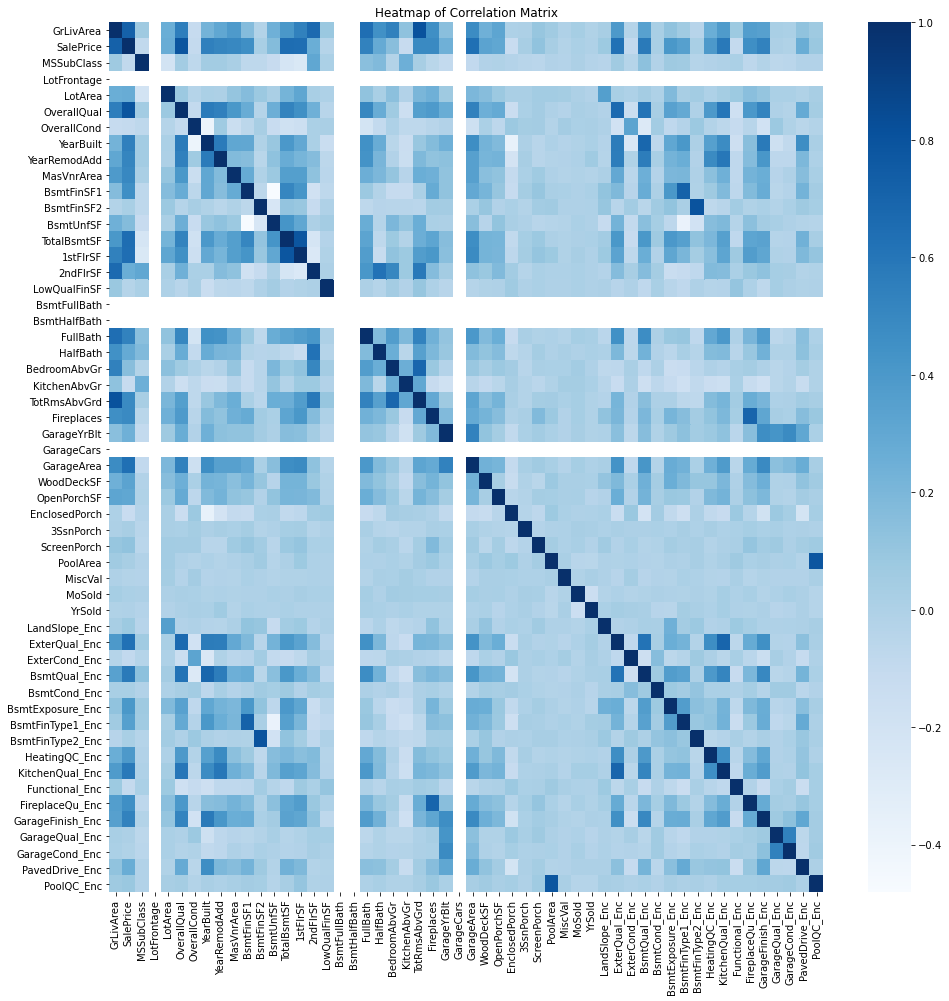

In [90]:
corr=housePrice.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap ="Blues")
plt.title('Heatmap of Correlation Matrix')
corr

In [91]:
high_corr_pairs = np.where(abs(corr) > 0.7)
high_corr_pairs = [(corr.index[x], corr.columns[y]) 
                   for x, y in  zip(*high_corr_pairs)
                   if x != y and x < y]

In [92]:
high_corr_pairs

[('GrLivArea', 'SalePrice'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('SalePrice', 'OverallQual'),
 ('BsmtFinSF1', 'BsmtFinType1_Enc'),
 ('BsmtFinSF2', 'BsmtFinType2_Enc'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('PoolArea', 'PoolQC_Enc')]

### High Correlation with SalePrice

In [93]:
top_corr_features = housePrice.corrwith(housePrice['SalePrice']).sort_values(ascending=False)
top_corr_features.where(top_corr_features > .6, inplace=True)
top_corr_features.dropna(inplace=True)
top_corr_features

SalePrice        1.000000
OverallQual      0.790501
GrLivArea        0.719981
TotalBsmtSF      0.652222
1stFlrSF         0.642613
GarageArea       0.634992
ExterQual_Enc    0.626728
dtype: float64

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


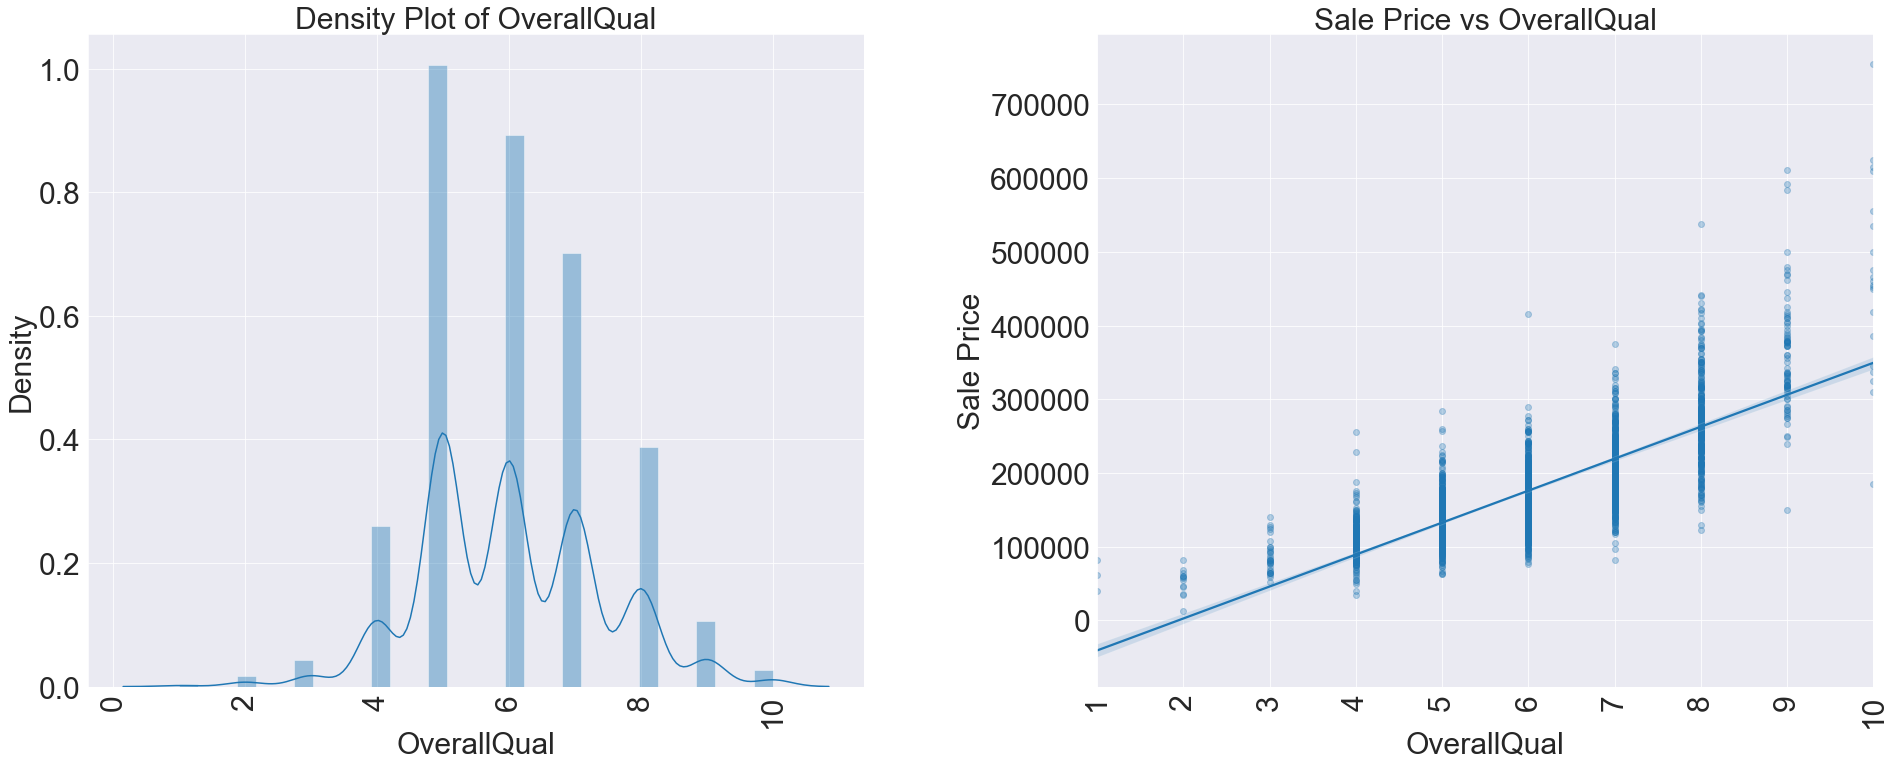

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


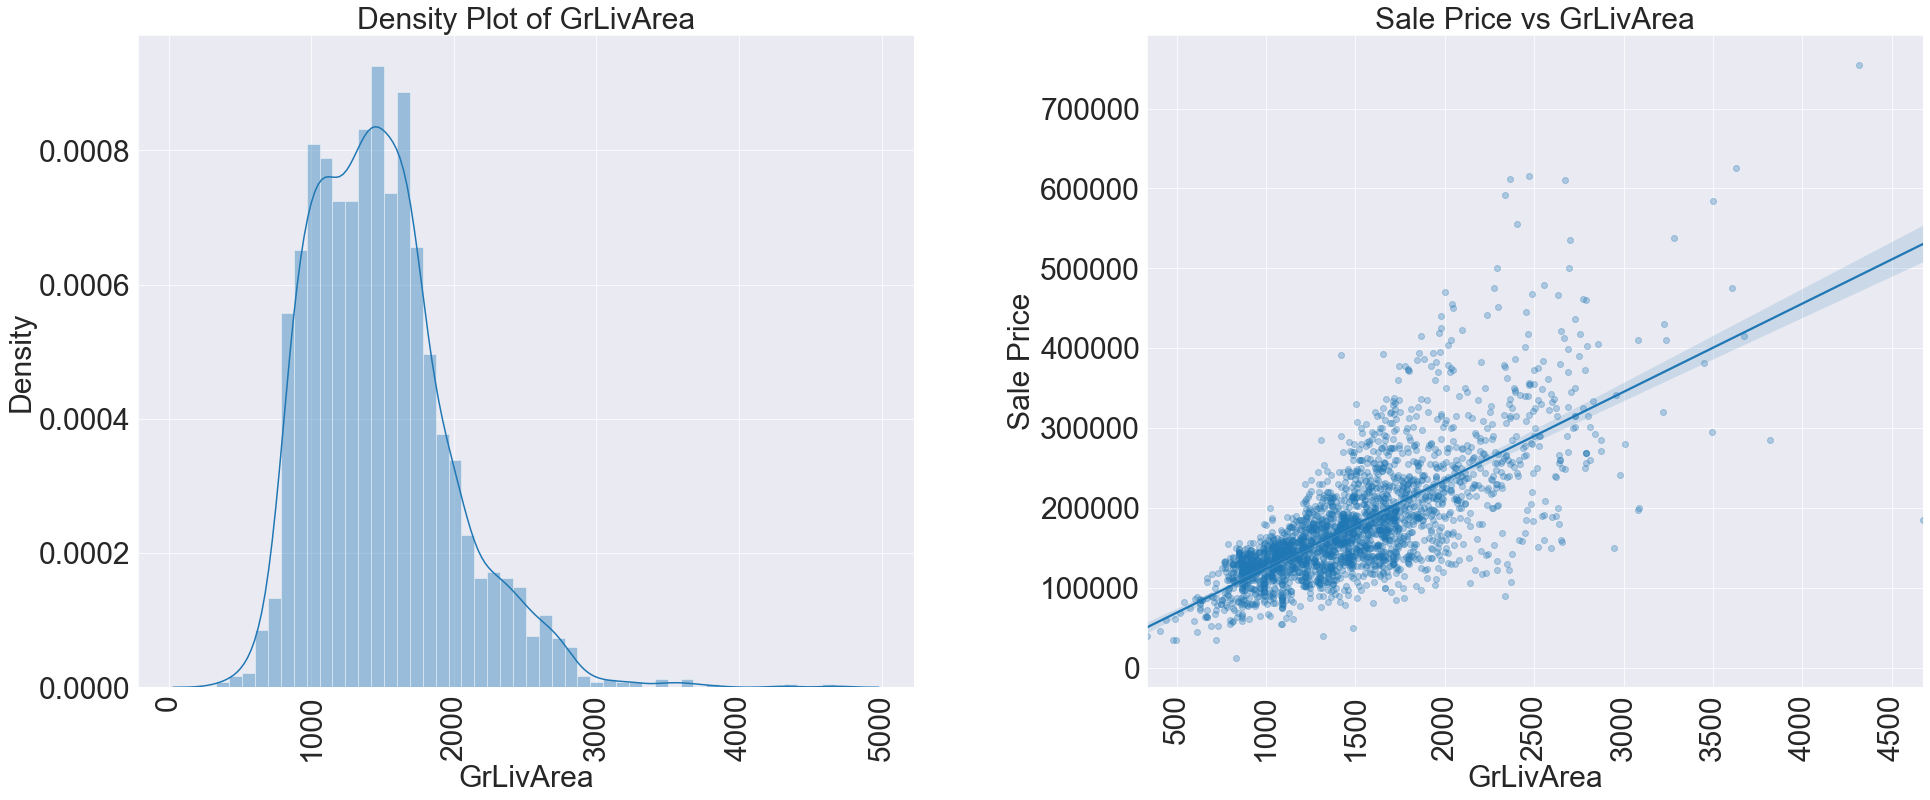

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


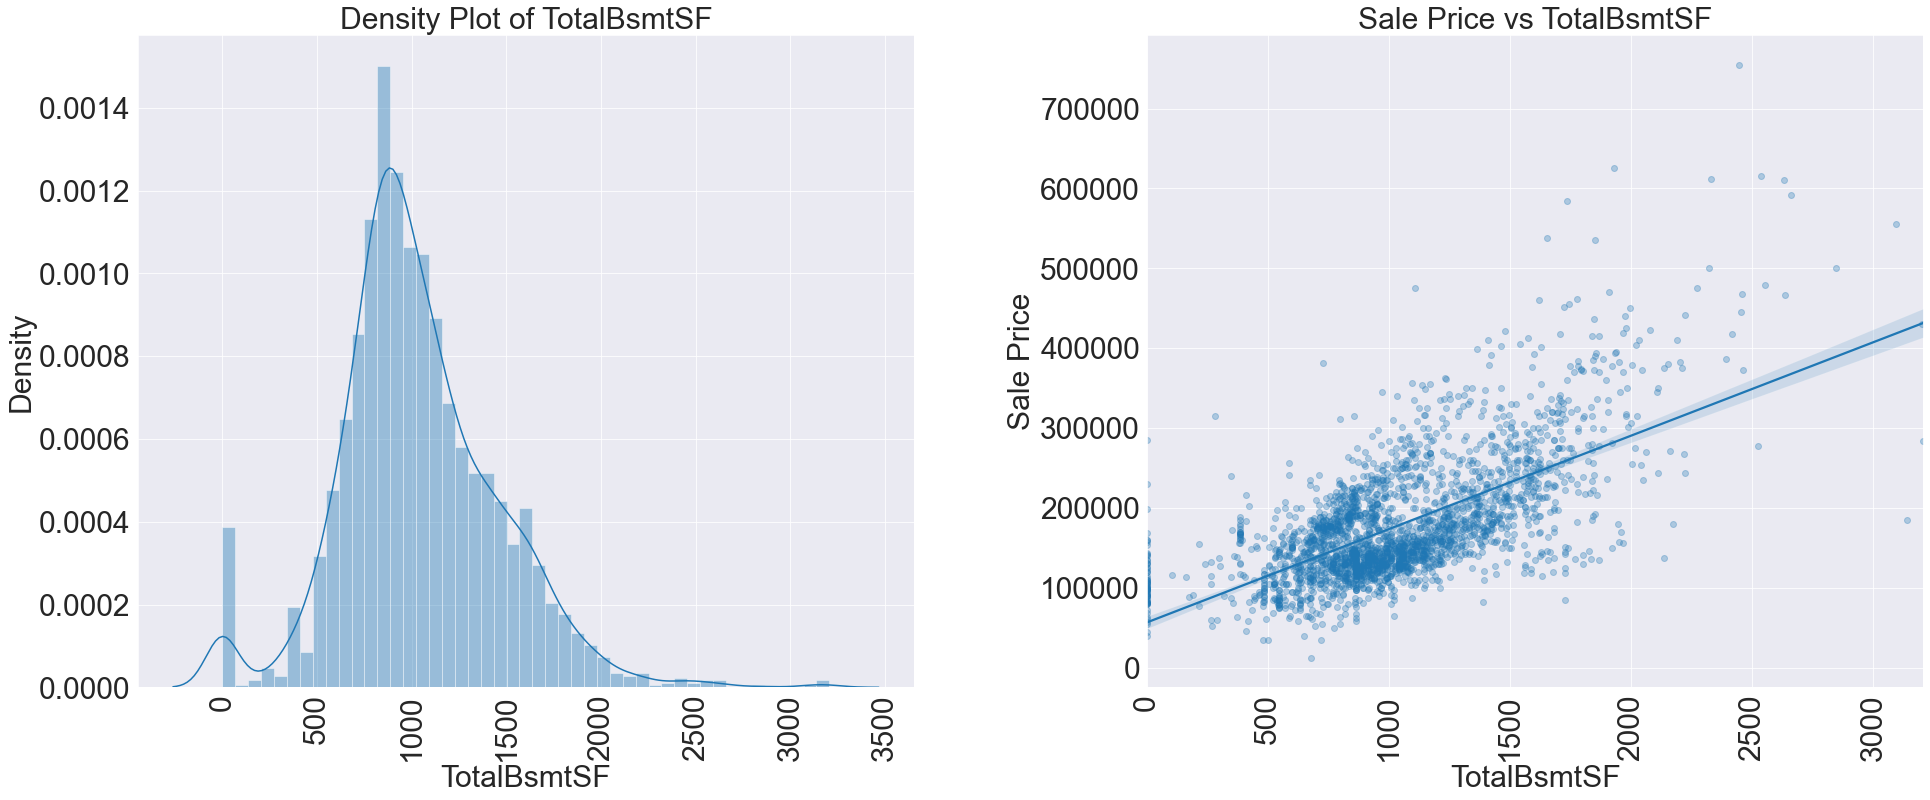

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


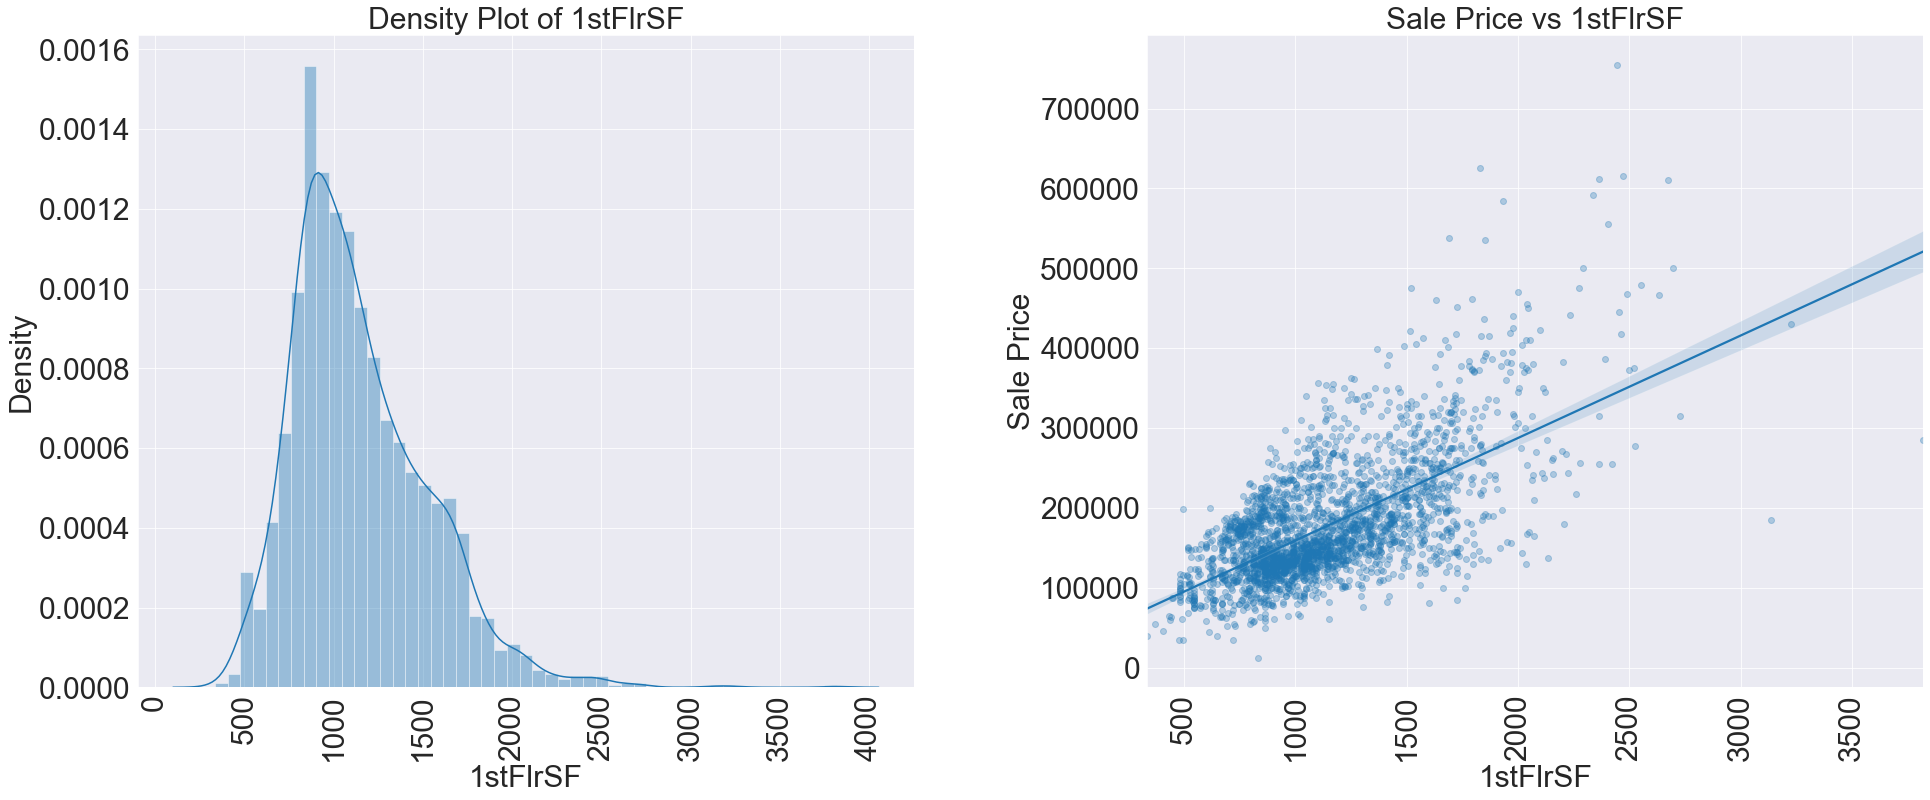

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


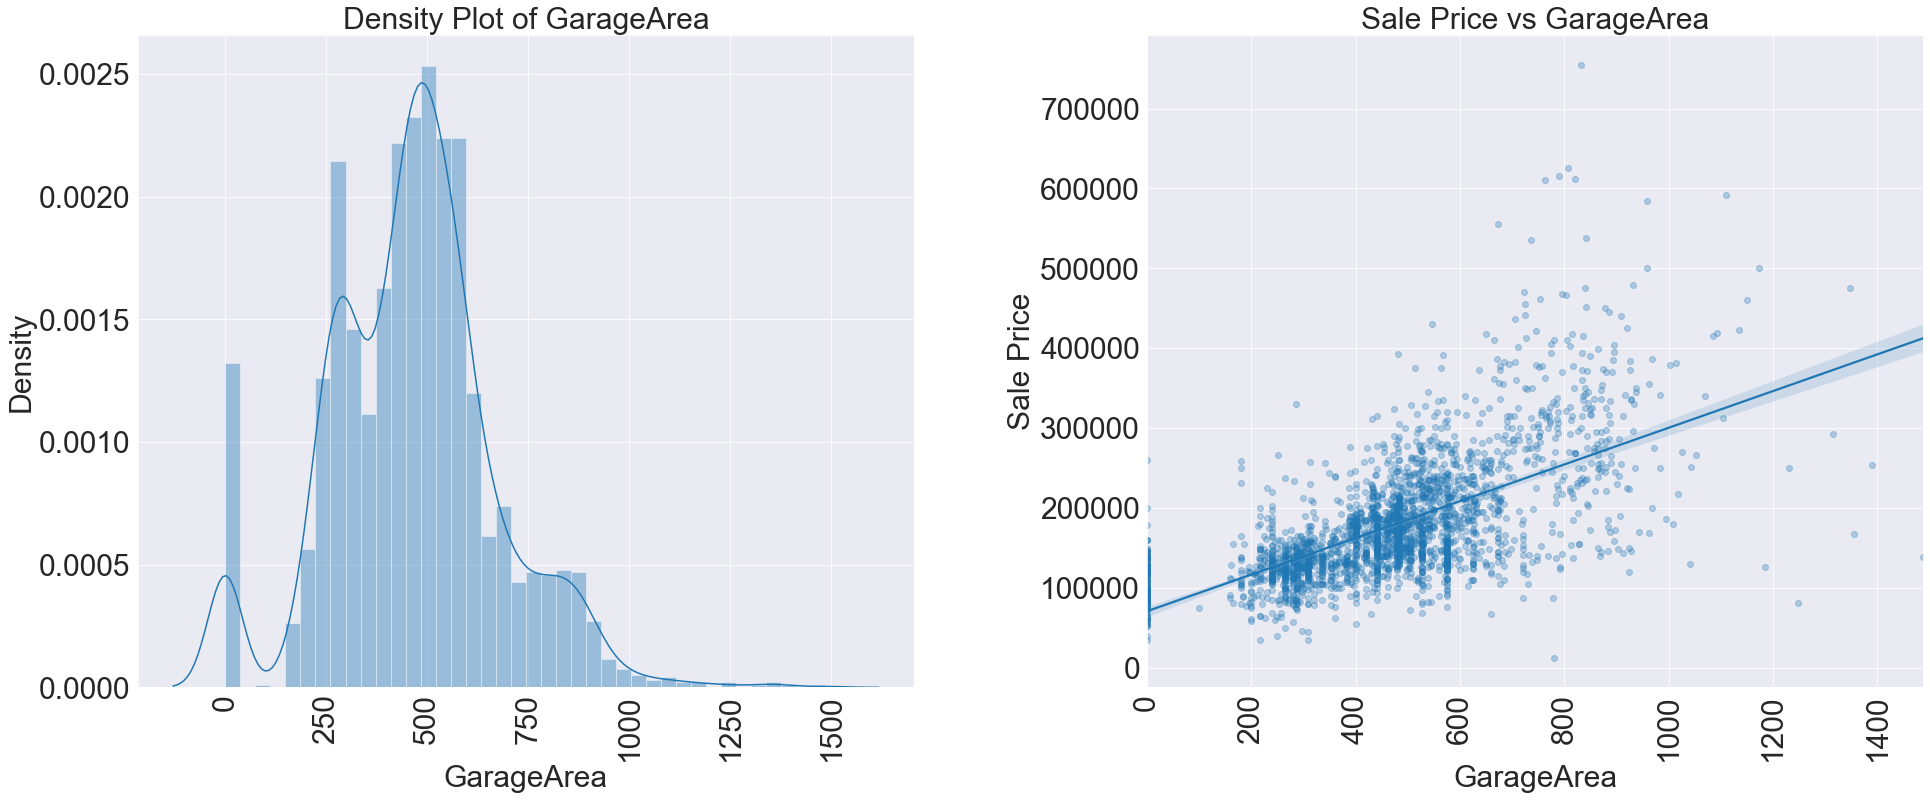

C:\Users\hzeig\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


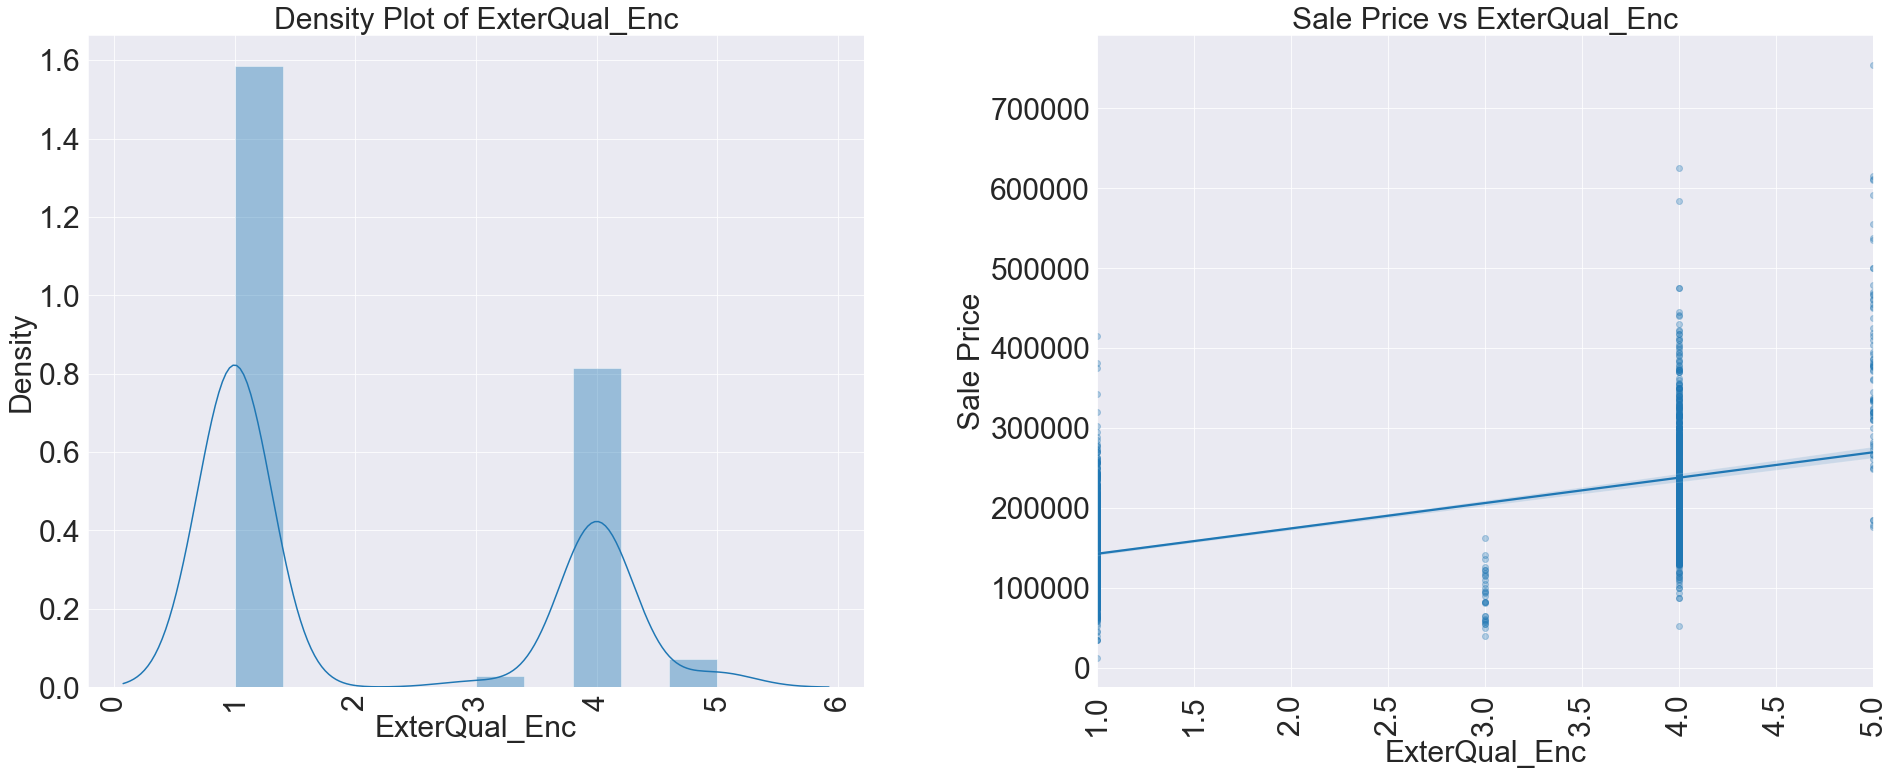

In [94]:
for feature in top_corr_features.index:
    if feature == 'SalePrice':
        continue
    feature_plot(housePrice, feature)

## Normalizing Skewed Features for Regression Models

C:\Users\hzeig\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\hzeig\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

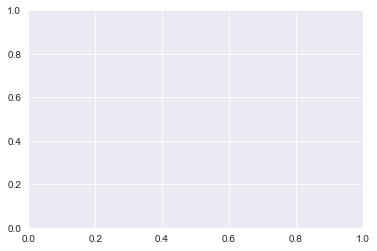

In [ ]:
features = pd.DataFrame(housePrice.columns, columns=['Features'])
features["Skew"] = scipy.stats.skew(housePrice)
features

## OneHot Encoding for nominals

In [ ]:
hp_num2 = housePrice.select_dtypes(include = [np.number])
hp_cat2 = housePrice.select_dtypes(exclude = [np.number])
print("numberfied:", hp_num2.shape[1])
print("to OneHot:", hp_cat2.shape[1])

In [ ]:
housePrice = pd.get_dummies(housePrice, columns=hp_cat_nom, drop_first=True)

In [ ]:
housePrice.to_csv('HousePrice_Encoded.csv')